In [90]:
import tarfile
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pd.set_option('display.max_columns', None)

In [91]:
#Load tar.gz file into Python
tar = tarfile.open("hitdata7days_0.tar.gz","r:gz")

In [ ]:
#tar.next() example. But be careful to reinstantiate tar when needed
tar = tarfile.open("hitdata7days_0.tar.gz","r:gz")
tar.next()

In [ ]:
#Extracting filename from TarInfo object
tn = tar.next()
tn.name

In [6]:
#Reading info from parquet file
pq.read_schema(tn.name)

hitdatahistorymkey: int64
filename: string
linenumber: int32
brandcode: string
visitoridhigh: decimal128(20, 0)
visitoridlow: decimal128(20, 0)
visitnumber: decimal128(10, 0)
visitdatetime: timestamp[ns]
visitdate: date32[day]
visitmonth: int32
fiscalyear: int16
fiscalmonthnumber: int16
fiscalweeknumber: int16
hit_time_gmt: decimal128(11, 0)
service: string
acceptlanguage: string
eventlist: string
homepage: string
ip: string
pageevent: decimal128(3, 0)
pageeventvar1: string
pageeventvar2: string
pagetype: string
pageurl: string
pagename: string
productlist: string
userserver: string
channel: string
sitesection: string
category: string
subcategory: string
subcategory2: string
pagecategory: string
searchterms: string
searchresults: string
refinementtype: string
refinementattribute: string
myaccountengagement: string
formanalysis: string
emailsubscriptionadd: string
emailsubscriptionremove: string
linklocation: string
navigationlinks: string
searchtype: string
businessunit: string
categor

In [7]:
#Read in parquet file as pandas DataFrame
df = pd.read_parquet(tn.name)

In [8]:
tar4 = tarfile.open("hitdata7days_6.tar.gz","r:gz")

In [9]:
tar4.extractall()

In [10]:
tar4 = tarfile.open("hitdata7days_6.tar.gz","r:gz")
tar4.next()

<TarInfo 'hitdata7days/visitday=16' at 0x7f7eeadbb040>

In [11]:
#Extracting filename from TarInfo object
tn4 = tar4.next()

In [12]:
pq.read_schema(tn4.name)

hitdatahistorymkey: int64
filename: string
linenumber: int32
brandcode: string
visitoridhigh: decimal128(20, 0)
visitoridlow: decimal128(20, 0)
visitnumber: decimal128(10, 0)
visitdatetime: timestamp[ns]
visitdate: date32[day]
visitmonth: int32
fiscalyear: int16
fiscalmonthnumber: int16
fiscalweeknumber: int16
hit_time_gmt: decimal128(11, 0)
service: string
acceptlanguage: string
eventlist: string
homepage: string
ip: string
pageevent: decimal128(3, 0)
pageeventvar1: string
pageeventvar2: string
pagetype: string
pageurl: string
pagename: string
productlist: string
userserver: string
channel: string
sitesection: string
category: string
subcategory: string
subcategory2: string
pagecategory: string
searchterms: string
searchresults: string
refinementtype: string
refinementattribute: string
myaccountengagement: string
formanalysis: string
emailsubscriptionadd: string
emailsubscriptionremove: string
linklocation: string
navigationlinks: string
searchtype: string
businessunit: string
categor

In [13]:
df4 = pd.read_parquet(tn4.name)

In [14]:
len(df['visitid'])

124867

In [15]:
len(df4['visitid'])

106559

In [16]:
df = pd.concat([df, df4], ignore_index = True)

## Select Columns

In [17]:
useful_columns = ['visitnumber',
                  'service', 
                  'emailsubscriptionremove', # change to boolean 
                  'refinementattribute2', # maximize, change to boolean
                  'prop29', # type of customer
                  'prop33', # Customer Lifestage Segment
                  'prop44', # Customer Attribute Tagging
                  'prop50', # error message change to boolean
                  'color', 'connectiontype',
                  'geocountry', 
                  'newvisit', 
                  'monthlyvisitor', 
                  'productfindingmethods',
                  'evar16', # attempted promocode                  
                  'evar28', # Marketing Segment Name
                  'clickactiontype',
                  'clickcontexttype', # boolean
                  'clicktag',
                  'devicetype',
                  'evar89',
                  'evar83',
                  'ordernumber',
                  'visitid'] 

In [18]:
df_clean = df[useful_columns]

In [19]:
# remove columns only contain one value (ex. None)
df_clean = df_clean.dropna(thresh=2, axis=1)
# replace none with NA
df_clean = df_clean.replace(['None'],np.nan)
df_clean = df_clean.replace(r'^\s*$', np.nan, regex=True)

## Column Modification

In [20]:
df_clean[['visitnumber', 'evar83']]=df_clean[['visitnumber', 'evar83']].apply(pd.to_numeric)

In [21]:
## Try!!!!
dff = df_clean.copy()
dff = dff.groupby('visitid').fillna(method = 'ffill')
dff['visitid'] = df_clean['visitid']

In [22]:
dff = dff.groupby('visitid').fillna(method = "bfill")

In [23]:
dff['visitid'] = df_clean['visitid']

In [24]:
df_clean = dff.copy()
df_clean[['remove_email']] = df_clean[['emailsubscriptionremove']].notnull()
df_clean[['close_look']] = df_clean[['refinementattribute2']].notnull()
df_clean[['error_message']] = df_clean[['prop50']].notnull()

df_clean[['clicktag']] = df_clean[['clicktag']].fillna('Noclick')
df_clean[['prop29']] = df_clean[['prop29']].fillna('unknown')
df_clean[['evar28']] = df_clean[['evar28']].fillna('unknown')
df_clean[['prop33']] = df_clean[['prop33']].fillna('unknown')
df_clean['productfindingmethods'] = df_clean['productfindingmethods'].fillna('other')
df_clean[['evar89']] = df_clean[['evar89']].fillna('unknown')

df_clean[['attempt_promo']] = df_clean[['evar16']].notnull()
df_clean[['prop44']] = df_clean[['prop44']].fillna('Others')

df_clean[['made_purchase']] = df_clean[['ordernumber']].notnull()

In [25]:
df_clean[['Marketing_Segment_Name']] = df_clean[['evar28']]
df_clean[['Type_of_customer']] = df_clean[['prop29']]
df_clean[['Customer_Lifestage_Segment']] = df_clean[['prop33']]
df_clean[['Customer_Attribute_Tagging']] = df_clean[['prop44']]
df_clean[['Paid_Search_Engine']] = df_clean[['evar89']]
df_clean[['Behavior_Score']] = df_clean[['evar83']]

## Drop Columns

In [26]:
df_clean = df_clean.drop(['ordernumber', 'emailsubscriptionremove', 'refinementattribute2',
                          'prop50', 'visitid', 'visitnumber', 'evar16', 'evar28', 'prop29',
                          'prop33', 'prop44', 'evar89', 'evar83', 'Behavior_Score'],
                          axis=1)

In [27]:
df_clean.isnull().mean().round(10).mul(100).sort_values(ascending=False)

service                       0.0
remove_email                  0.0
Customer_Attribute_Tagging    0.0
Customer_Lifestage_Segment    0.0
Type_of_customer              0.0
Marketing_Segment_Name        0.0
made_purchase                 0.0
attempt_promo                 0.0
error_message                 0.0
close_look                    0.0
devicetype                    0.0
color                         0.0
clicktag                      0.0
clickcontexttype              0.0
clickactiontype               0.0
productfindingmethods         0.0
monthlyvisitor                0.0
newvisit                      0.0
geocountry                    0.0
connectiontype                0.0
Paid_Search_Engine            0.0
dtype: float64

In [28]:
corr_matrix = df_clean.corr().abs()

high_corr_var=np.where(corr_matrix>0.7)
high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]

## Resample Dataset

In [29]:
df_purchase = df_clean[df_clean['made_purchase']==1]
df_not_purchase = df_clean[df_clean['made_purchase']==0]
len(df_purchase)

55659

In [30]:
len(df_not_purchase)

175767

In [31]:
df_purchase_sample = df_purchase.sample(60000, random_state = 2001, replace=True)
df_not_purchase_sample = df_not_purchase.sample(60000, random_state = 2001, replace=True)
df_sample = pd.concat([df_purchase_sample, df_not_purchase_sample])

In [32]:
df_clean = df_sample.copy()

## Gradient Boosting Classifier

In [33]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import HistGradientBoostingClassifier

In [34]:
for column in df_clean.columns:
    le = LabelEncoder()
    labels = le.fit_transform(df_clean[column])
    df_clean[column] = labels

In [35]:
# Split the data into features (X) and target (y)
X = df_clean.drop(['made_purchase'], axis=1)
y = df_clean['made_purchase']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [36]:
clf = HistGradientBoostingClassifier().fit(X, y)
clf.fit(X_train, y_train)

HistGradientBoostingClassifier()

In [37]:
clf.score(X_test, y_test)

0.8709166666666667

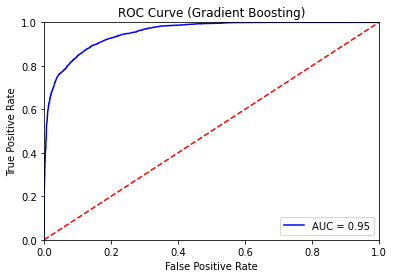

In [38]:
# ROC curve

probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC Curve (Gradient Boosting)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## XGBoost

In [102]:
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance

In [103]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [104]:
xgb_model.score(X_test, y_test)

0.8971111111111111

In [105]:
from matplotlib import pyplot as plt

<Figure size 1440x576 with 0 Axes>

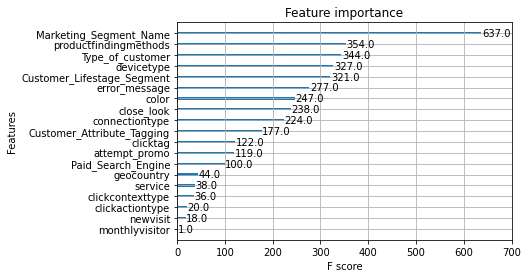

In [106]:
plt.figure(figsize=(20,8))
plot_importance(xgb_model)
plt.show()

In [107]:
y_preds = xgb_model.predict(X_test)
confusion_matrix(y_test, y_preds)

array([[16256,  1801],
       [ 1903, 16040]])

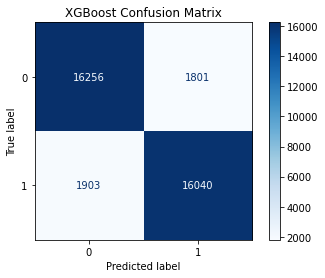

In [108]:
cm = confusion_matrix(y_test, y_preds, labels = xgb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb_model.classes_)
disp.plot(cmap=plt.cm.Blues) 
disp.ax_.set_title("XGBoost Confusion Matrix")
plt.show()

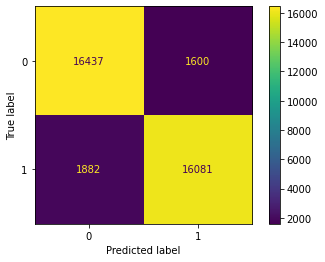

In [47]:
cm = confusion_matrix(y_test, y_preds, labels=xgb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot()
plt.savefig('xgb_confusion.png')
plt.show()

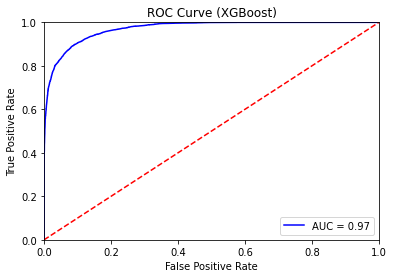

In [49]:
# ROC curve

probs = xgb_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC Curve (XGBoost)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('roc_xgb.png')
plt.show()

## Random Forest

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)
rf_model = RandomForestClassifier(n_estimators=50, max_features="auto", random_state=44)
rf_model.fit(X_train, y_train)

/Users/amytang10/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_features='auto', n_estimators=50, random_state=44)

In [111]:
rf_model.score(X_test, y_test)

0.9194444444444444

In [54]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.savefig('rf_importance.png')

In [88]:
import seaborn as sns

def plot_feature_importance(importance, names, model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    
    #Plot Searborn bar chart
    colors = ['#155084' if (idx <= 1) else '#9dbcd4' for idx, x in enumerate(feature_importance)]
    
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette = colors)
    
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
    #Add chart labels
    if model_type.upper() == "RANDOM FOREST":
        plt.title(model_type + ' FEATURE IMPORTANCE')
        plt.xlabel('FEATURE IMPORTANCE')
        plt.ylabel('FEATURE NAMES')
        
    if model_type.upper() == "XGBOOST":
        plt.title(model_type + ' FEATURE IMPORTANCE')
        plt.xlabel('F1 Score')
        plt.ylabel('FEATURE NAMES')
        
    plt.savefig('rf_importance.png')

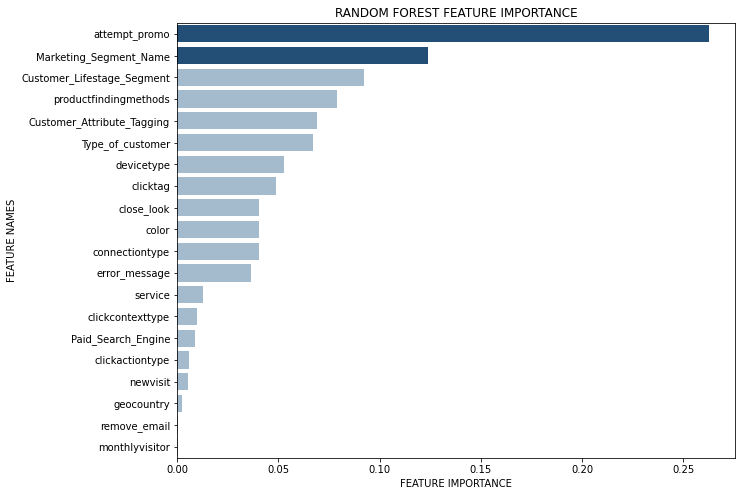

In [89]:
plot_feature_importance(rf_model.feature_importances_, X.columns, 'RANDOM FOREST')

In [112]:
y_preds = rf_model.predict(X_test)
confusion_matrix(y_test, y_preds)

array([[16413,  1644],
       [ 1256, 16687]])

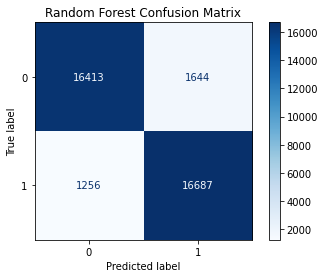

In [113]:
cm = confusion_matrix(y_test, y_preds, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap=plt.cm.Blues) 
disp.ax_.set_title("Random Forest Confusion Matrix")
plt.show()

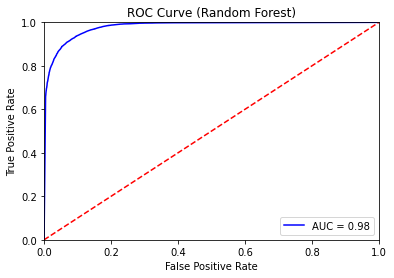

In [58]:
# ROC curve

probs = rf_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC Curve (Random Forest)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('roc_rf.png')
plt.show()

## Logistic Regression

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [98]:
logit_model = LogisticRegression(solver='liblinear', random_state=0)
logit_model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [99]:
logit_model.score(X_test, y_test)

0.7514444444444445

In [100]:
y_preds = logit_model.predict(X_test)

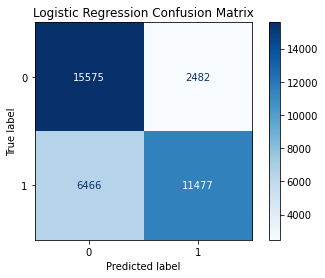

In [101]:
cm = confusion_matrix(y_test, y_preds, labels=logit_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logit_model.classes_)
disp.plot(cmap=plt.cm.Blues) 
disp.ax_.set_title("Logistic Regression Confusion Matrix")
plt.show()

In [103]:
print(logit_model.coef_, logit_model.intercept_)

[[-0.04744417  0.05999579  0.10170905  0.01181609 -1.35202384 -0.62639845
  -0.16773632  0.18743483  0.03230076  0.06108752 -0.2729124   2.79265454
   0.17346335  0.46663199  2.79212752  0.00959077  0.00467966 -0.07891524
  -0.47786281 -0.07322037]] [-2.01510145]


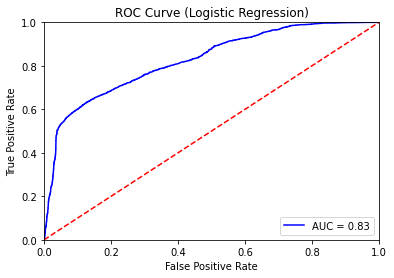

In [64]:
# ROC curve

probs = logit_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC Curve (Logistic Regression)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('roc_logistic.png')
plt.savefig('roc_logit.png')
plt.show()